In [1]:
import os
import glob
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
from models import *
from predict import SRImage
import cv2
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

In [2]:
dataset_folder = os.path.abspath('dataset')
dataset_parameters = {'train_low_res':'LR/DIV2K_train_LR_bicubic',
                     'val_low_res': 'LR/DIV2K_valid_LR_bicubic',
                     'data_directory': dataset_folder}

In [3]:
def load_image(path):
    img = Image.open(path)
    
    isGray = len(img.getbands()) == 1
    
    if isGray or len(img.getbands()) == 4:
        img = img.convert('RGB')
    
    return isGray, np.array(img)

In [4]:
file_path = os.path.abspath("weights/srganGenerator.h5")
if not os.path.exists(file_path):
    os.makedirs(weights_directory, exist_ok=True)
    
    print(f"The file: {file_path} is not found")
file_path

'F:\\Study\\CS\\computer vision\\term project\\weights\\srganGenerator.h5'

In [5]:
model = generatorNet()
model.load_weights(file_path)

In [6]:
results_path = "output/"
os.makedirs(results_path, exist_ok=True)

In [16]:
num_examples = 100
image_paths = glob.glob("dataset/LR/DIV2K_valid_LR_bicubic/*")[:num_examples]

# Get super resolution images
SRs = []
for image_path in image_paths:
    # load the image
    isGray, lr = load_image(image_path)
    # get the super resolution image
    sr = SRImage(model, lr)
    # convert to gray if it was gray
    if isGray:
        sr = ImageOps.grayscale(sr)
    SRs.append(sr)
    image_name = image_path.split("\\")[-1]
    sr.save(f"{results_path}{image_name}" )

In [17]:
image_paths = glob.glob("dataset/HR/DIV2K_valid_HR/*")[:num_examples]

# Load the High resolution images
HRs = []
for image_path in image_paths:
    #print(image_path)
    was_grayscale, hr = load_image(image_path)
    
    if was_grayscale:
        hr = ImageOps.grayscale(hr)
    HRs.append(hr)


In [18]:
image_paths = glob.glob("dataset/LR/DIV2K_valid_LR_bicubic/*")[:num_examples]
# get the uscaled images using bicubic interpolation
bicubics = []
for image_path in image_paths:
    #print(image_path)
    lr = cv2.imread(image_path)
    bc = cv2.resize(lr,None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)
    bicubics.append(bc)


In [19]:
# Calculate the Average PSNR and SSIM for SRGAN

psnrs_SR=[] # psnr values will be stored here

ssims_SR=[] # SSIM values will be stored here

for sr,hr in zip(SRs,HRs):
    
    sr = np.array(sr) 
    # Convert RGB to BGR 
    sr = sr[:, :, ::-1].copy() 
    
    hr = np.array(hr) 
    # Convert RGB to BGR 
    hr = hr[:, :, ::-1].copy()
    
    # calculate ssim of the images    
    graySR = cv2.cvtColor(sr, cv2.COLOR_BGR2GRAY)
    grayHR= cv2.cvtColor(hr, cv2.COLOR_BGR2GRAY)
    score, _ = ssim(graySR, grayHR, full=True)
    ssims_SR.append(score)
    
    psnr = cv2.PSNR(graySR, grayHR)
    psnrs_SR.append(psnr)

# for ssim in ssims:
#     print(f"SSIM:{ssim}")

print(f"Average SSIM for SRGAN is: {sum(ssims_SR)/len(ssims_SR) :.2f}")
print(f"Average PSNR for SRGAN is: {sum(psnrs_SR)/len(psnrs_SR): .2f}")

Average SSIM for SRGAN is: 0.83
Average PSNR for SRGAN is:  28.93


In [20]:
# Bicubic Interpolation

ssims_BC=[]
# psnr
psnrs_BC=[]
for bc,hr in zip(bicubics,HRs):
     
    
    hr = np.array(hr) 
    # Convert RGB to BGR 
    hr = hr[:, :, ::-1].copy()
    
    # calculate ssim of the images    
    grayA = cv2.cvtColor(bc, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(hr, cv2.COLOR_BGR2GRAY)
    score, diff = ssim(grayA, grayB, full=True)
    ssims_BC.append(score)
    
    # psnr
    psnr = cv2.PSNR(grayA, grayB)
    psnrs_BC.append(psnr)

# for ssim in ssims:
#     print(f"SSIM:{ssim}")

print(f"Average SSIM for Bicubic interpolation is: {sum(ssims_BC)/len(ssims_BC) :.2f}")
print(f"Average PSNR for Bicubic interpolation is: {sum(psnrs_BC)/len(psnrs_BC) :.2f}")

Average SSIM for Bicubic interpolation is: 0.77
Average PSNR for Bicubic interpolation is: 26.91


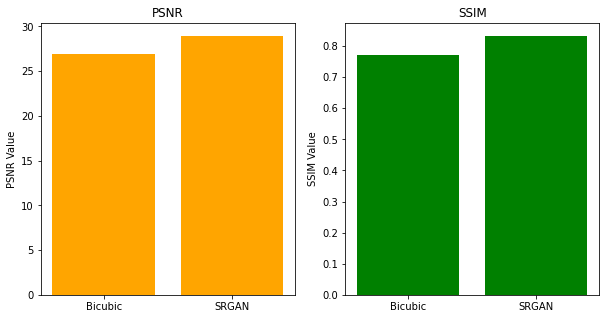

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5));

labels = ["Bicubic", "SRGAN"]
avg_PSNR_values = [sum(psnrs_BC)/len(psnrs_BC), sum(psnrs_SR)/len(psnrs_SR)]
ax[0].bar(labels,avg_PSNR_values, color='orange');
ax[0].set_title('PSNR');
ax[0].set_ylabel('PSNR Value');

avg_SSIM_values = [sum(ssims_BC)/len(ssims_BC), sum(ssims_SR)/len(ssims_SR)]
ax[1].bar(labels, avg_SSIM_values, color='green');
ax[1].set_title('SSIM');
ax[1].set_ylabel('SSIM Value');

plt.show()